# SOLA Method with Noise: Property Inference from Noisy Observations

## The Continuous Problem

We address the task of estimating a finite‐dimensional property of an unknown model from noisy observations. This is a classic problem in inverse theory where we seek to infer localized properties without explicitly reconstructing the full model.

Let $m \in \mathcal{M}$ be the unknown model in a separable Hilbert space, $\mathbf{\tilde{d}} \in \mathcal{D} \cong \mathbb{R}^{N_d}$ be the observed data, and $\mathbf{\tilde{p}} \in \mathcal{P} \cong \mathbb{R}^{N_p}$ be the desired properties, where $\mathcal{D}$ and $\mathcal{P}$ are Euclidean spaces of dimensions $N_d$ and $N_p$ respectively.

### Forward Operator and Data Model

The forward map is a bounded linear operator:
$$
G:\mathcal{M}\to \mathcal{D}, \qquad [G(m)]_i = \langle K_i, m \rangle_{\mathcal{M}}
$$

where $K_i \in \mathcal{M}$ are sensitivity kernels. The observed data is modeled as:
$$
\mathbf{\tilde{d}} = G(\bar{m}) + \bm{\eta}
$$

where $\bar{m}$ is the true (unknown) model and $\bm{\eta}$ represents additive noise. We model the data with a Gaussian measure:
$$
\mu_{\mathcal{D}} = \mathcal{N}(\mathbf{\tilde{d}}, \mathbf{C}_{\mathcal{D}})
$$

### Property Extraction

Similarly, the property of interest is extracted via:
$$
\mathcal{T}:\mathcal{M}\to \mathcal{P}, \qquad [\mathcal{T}(m)]_k = \langle T^{(k)}, m \rangle_{\mathcal{M}}
$$

where $T^{(k)} \in \mathcal{M}$ are the target kernels. Our ultimate goal is to recover:
$$
\bar{\mathbf{p}} = \mathcal{T}(\bar{m})
$$

### SOLA Approach

Since the inverse problem is ill‐posed, we do not attempt to reconstruct $\bar{m}$ directly. Instead, we seek a surrogate operator:
$$
\mathbf{X}:\mathcal{D} \to \mathcal{P}
$$

that approximates the composition $\mathcal{T} \circ G^{-1}$ on the most probable models. We enforce:
$$
\mathcal{T} \approx \mathbf{X}G
$$

and measure the discrepancy in the Hilbert–Schmidt norm while minimizing property uncertainty.

## SOLA Optimization Problem

We seek $\mathbf{X}$ as the solution to:
$$
\boxed{
\min_{\mathbf{X}} \left[ \|\mathcal{T} - \mathbf{X}G\|_{HS}^2 + \text{Tr}(\mathbf{X} \mathbf{C}_{\mathcal{D}} \mathbf{X}^*) \right]
}
$$

where $\|A\|_{HS}^2 = \text{Tr}(A A^*)$ is the Hilbert–Schmidt norm.

### Analytical Solution

The optimal operator is:
$$
\boxed{
\mathbf{X} = \mathcal{T} G^*(GG^* + \mathbf{C}_{\mathcal{D}})^{-1}
}
$$

### Property Measure

From this, we obtain the property measure by pushing forward the data measure:
$$
\mu_{\mathcal{P}} = \mathbf{X}_* \mu_{\mathcal{D}} = \mathcal{N}(\mathbf{\tilde{p}}, \mathbf{C}_{\mathcal{P}})
$$

where:
- **Property mean**: $\mathbf{\tilde{p}} = \mathbf{X}(\mathbf{\tilde{d}})$
- **Property covariance**: $\mathbf{C}_{\mathcal{P}} = \mathbf{X} \mathbf{C}_{\mathcal{D}} \mathbf{X}^*$

In [18]:
from pygeoinf.interval.function_providers import NormalModesProvider, BumpFunctionProvider
from pygeoinf.interval.interval_domain import IntervalDomain
from pygeoinf.interval.l2_space import L2Space
from pygeoinf.hilbert_space import EuclideanSpace, LinearOperator
from pygeoinf.interval.sola_operator import SOLAOperator
from pygeoinf.interval.l2_functions import Function
from pygeoinf.linear_solvers import CholeskySolver
from pygeoinf.gaussian_measure import GaussianMeasure
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Set-up folder for saving figures
import os
figures_folder = 'sola_noise_figures'
if not os.path.exists(figures_folder):
    os.makedirs(figures_folder)

## Creating the Spaces

We first create the function domain as an interval $[0,1]$. The model space will be an $L^2$ space with $N$ basis functions. We also define the data space $\mathcal{D} \cong \mathbb{R}^{N_d}$ and property space $\mathcal{P} \cong \mathbb{R}^{N_p}$ as finite-dimensional Euclidean spaces.

In [19]:
# Create a function domain and spaces
function_domain = IntervalDomain(0, 1)
N = 30  # number of basis functions for model space
M = L2Space(N, function_domain, basis_type='sine')  # model space
N_d = 100  # number of data points
D = EuclideanSpace(N_d)  # data space
N_p = 20  # number of property points
P = EuclideanSpace(N_p)  # property space

## Create Mappings

We now create the linear operators that define our problem:

1. **Forward operator $G$**: Maps from model space to data space using normal mode sensitivity kernels
2. **Target operator $\mathcal{T}$**: Maps from model space to property space using localized bump function kernels

The sensitivity kernels determine how sensitive each measurement is to different parts of the model, while the target kernels define the spatial localization of the properties we want to infer.

In [20]:
# Create forward and property mappings
width = 0.2 # width of the bump target functions
centers = np.linspace(function_domain.a + width / 2, function_domain.b - width / 2, N_p) # centers of the bumps
# Create a normal modes provider for the forward operator
# and a bump function provider for the target operator
# Note: The random_state is set to ensure reproducibility of results
normal_modes_provider = NormalModesProvider(M, gaussian_width_percent_range=(5, 10),
                                            freq_range=(5, 10), random_state=39)
G = SOLAOperator(M, D, normal_modes_provider, integration_method='trapz', n_points=1000)
target_provider = BumpFunctionProvider(M, centers=centers, default_width=width)
T = SOLAOperator(M, P, target_provider, integration_method='trapz', n_points=1000)

/home/adrian/PhD/Inferences/pygeoinf/pygeoinf/interval/l2_functions.py:265: UserWarning: Point evaluation is not well-defined for general L² functions. Consider using a Sobolev space with s > 1/2 for point evaluation.
  warnings.warn(


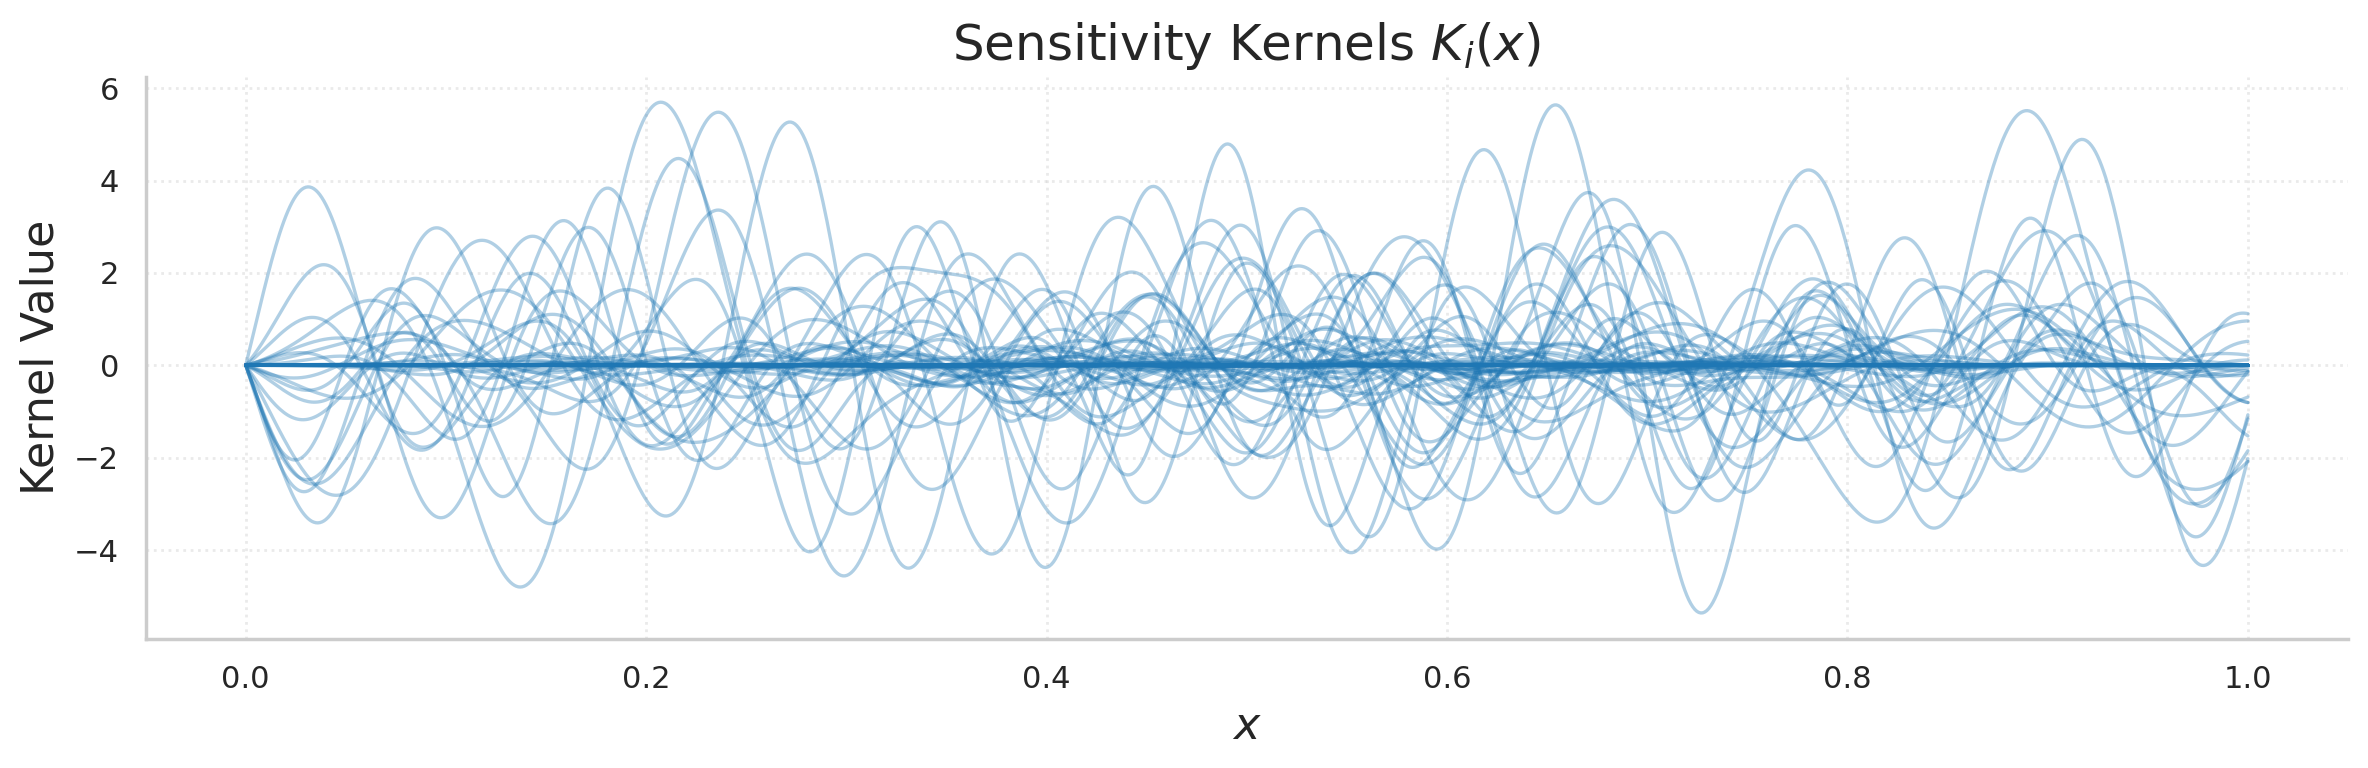

In [21]:
# Publication-quality Sensitivity Kernels figure
fig_title = "Sensitivity Kernels"
filename = os.path.join(figures_folder, fig_title.replace(" ", "_").lower() + ".png")

x = np.linspace(function_domain.a, function_domain.b, 1000)

sns.set_theme(style="whitegrid", palette="muted", color_codes=True)
plt.figure(figsize=(12, 4), dpi=200)

# Plot all kernels in a single color - overlapping areas show regions of high sensitivity
for i in range(N_d):
    plt.plot(
        x,
        G.function_provider.get_function_by_index(i).evaluate(x),
        color='tab:blue',
        alpha=0.35,
        linewidth=1.2
    )

plt.title(r"Sensitivity Kernels $K_i(x)$", fontsize=18)
plt.xlabel(r"$x$", fontsize=16)
plt.ylabel("Kernel Value", fontsize=16)
plt.tight_layout()
plt.grid(True, linestyle=':', alpha=0.4)
sns.despine()

# Save as both PNG and PDF for publication
plt.savefig(filename, dpi=300, bbox_inches='tight')
plt.savefig(filename.replace('.png', '.pdf'), bbox_inches='tight')
plt.show()

### Sensitivity Kernels Analysis

The sensitivity kernels $K_i(x)$ define how sensitive each data point $d_i$ is to the model $m(x)$ at different spatial locations. These kernels are crucial for understanding:

- **Coverage**: Where in the domain we have observational sensitivity
- **Resolution**: How localized our measurements are  
- **Redundancy**: Overlapping kernels indicate multiple measurements of similar information

Regions where many kernels overlap (appearing darker) represent areas of high observational density, while sparse regions indicate limited sensitivity.

/home/adrian/PhD/Inferences/pygeoinf/pygeoinf/interval/l2_functions.py:265: UserWarning: Point evaluation is not well-defined for general L² functions. Consider using a Sobolev space with s > 1/2 for point evaluation.
  warnings.warn(


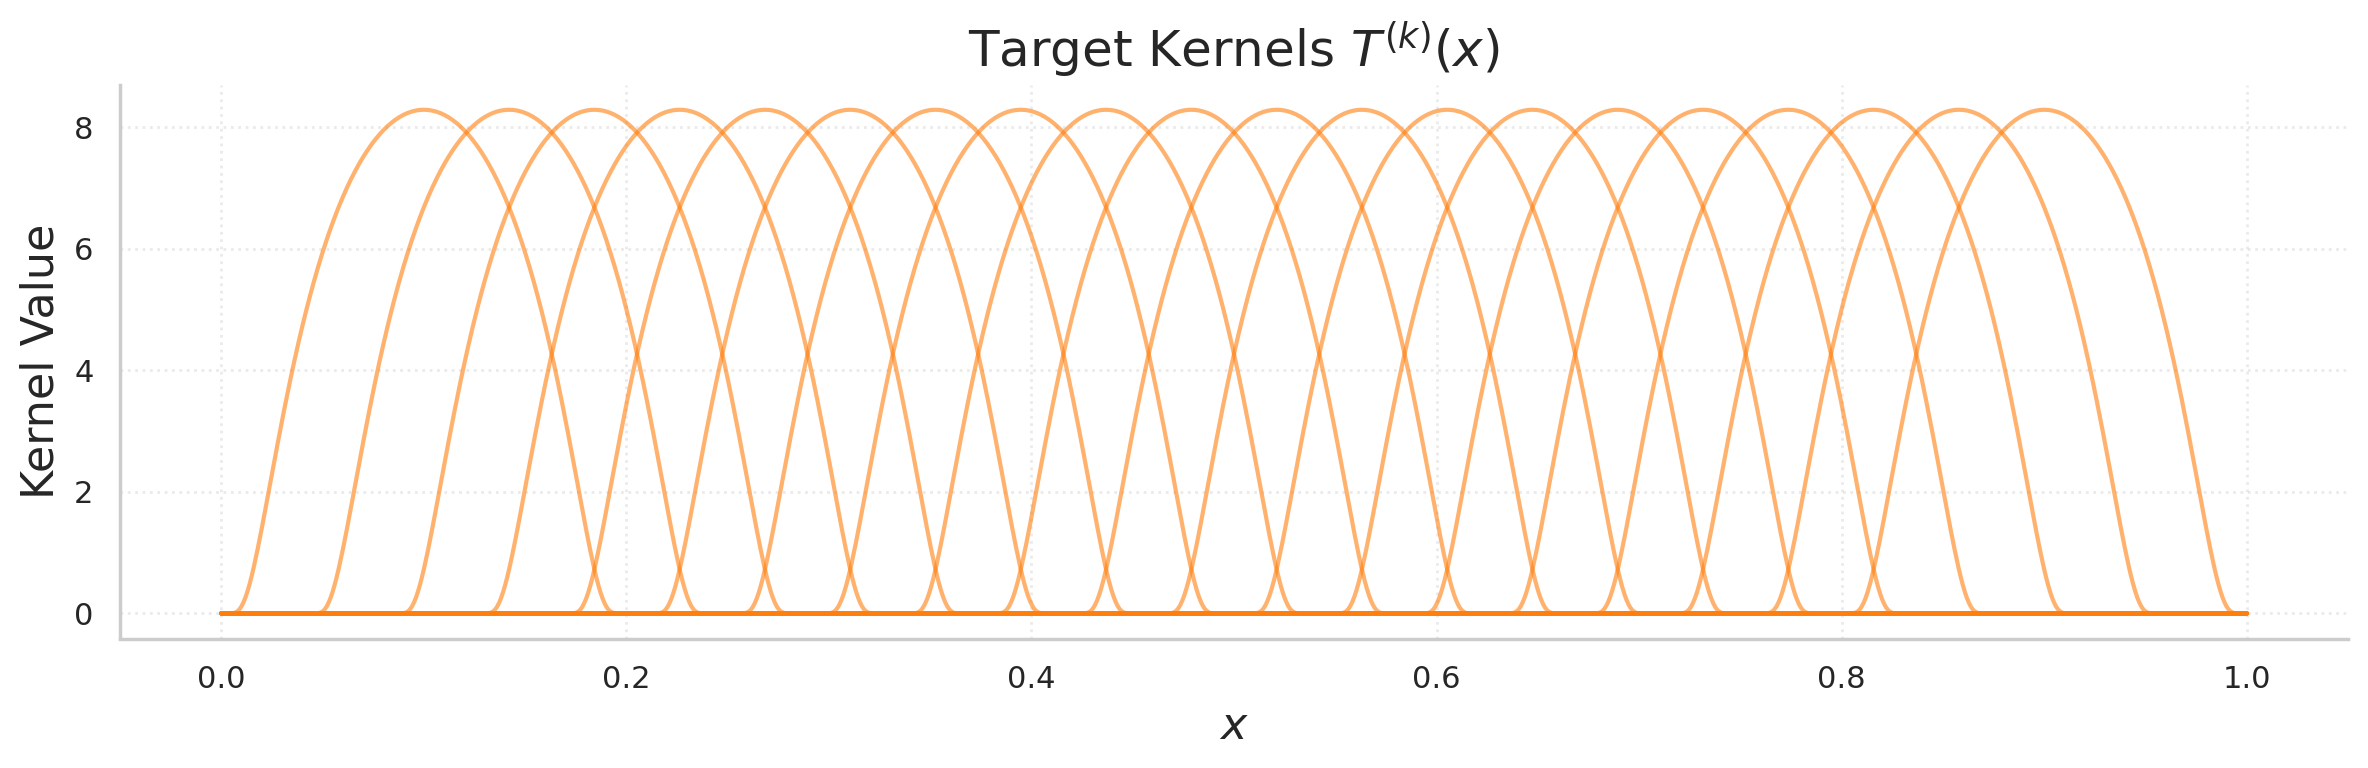

In [22]:
# Publication-quality Target Kernels figure
fig_title = "Target Kernels"
filename = os.path.join(figures_folder, fig_title.replace(" ", "_").lower() + ".png")

plt.figure(figsize=(12, 4), dpi=200)
for i in range(N_p):
    plt.plot(
        x,
        T.function_provider.get_function_by_index(i).evaluate(x),
        color='tab:orange',
        alpha=0.6,
        linewidth=1.5
    )

plt.title(r"Target Kernels $T^{(k)}(x)$", fontsize=18)
plt.xlabel(r"$x$", fontsize=16)
plt.ylabel("Kernel Value", fontsize=16)
plt.tight_layout()
plt.grid(True, linestyle=':', alpha=0.4)
sns.despine()

# Save as both PNG and PDF
plt.savefig(filename, dpi=300, bbox_inches='tight')
plt.savefig(filename.replace('.png', '.pdf'), bbox_inches='tight')
plt.show()

### Target Kernels for Property Extraction

The target kernels $T^{(k)}(x)$ define the properties we want to infer about the model. Each kernel extracts a local average of the model around its center location. These bump functions allow us to:

- **Localize**: Extract spatially localized properties
- **Regularize**: Smooth local estimates through spatial averaging
- **Focus**: Target specific regions of interest in the domain

The width of each bump determines the spatial resolution of the property extraction - narrower bumps give higher spatial resolution but may be more sensitive to noise.

## Synthetic Data Generation

### True Model Construction

We create a synthetic "true" model $\bar{m}(x)$ to test our SOLA method:

$$\bar{m}(x) = \sin(2\pi x)$$

This simple sinusoidal model provides a smooth, oscillatory function that will test our ability to recover localized properties from noisy observations.

From this true model, we generate synthetic observations $\mathbf{\bar{d}} = G(\bar{m})$ and add noise to create realistic measurements $\mathbf{\tilde{d}}$.

/home/adrian/PhD/Inferences/pygeoinf/pygeoinf/interval/l2_functions.py:265: UserWarning: Point evaluation is not well-defined for general L² functions. Consider using a Sobolev space with s > 1/2 for point evaluation.
  warnings.warn(


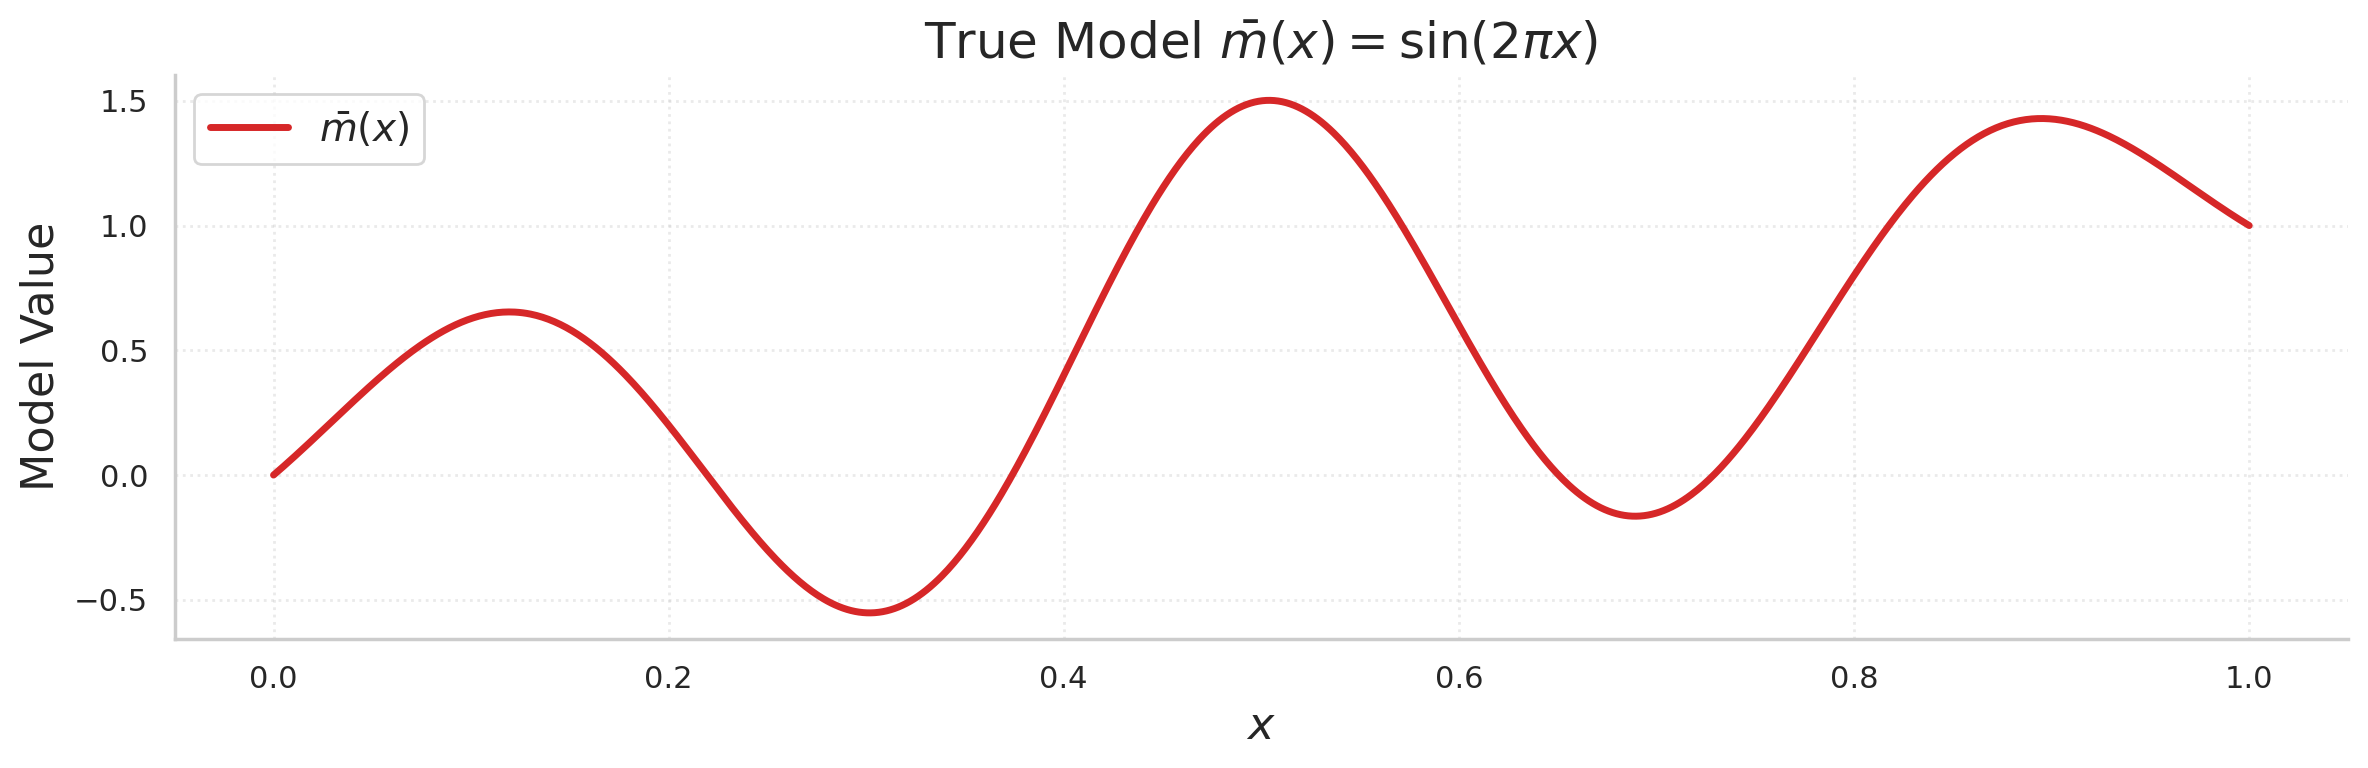

Generating synthetic data...
Signal-to-noise ratio: 10.0
Number of observations: 100


/home/adrian/PhD/Inferences/pygeoinf/pygeoinf/interval/l2_functions.py:265: UserWarning: Point evaluation is not well-defined for general L² functions. Consider using a Sobolev space with s > 1/2 for point evaluation.
  warnings.warn(


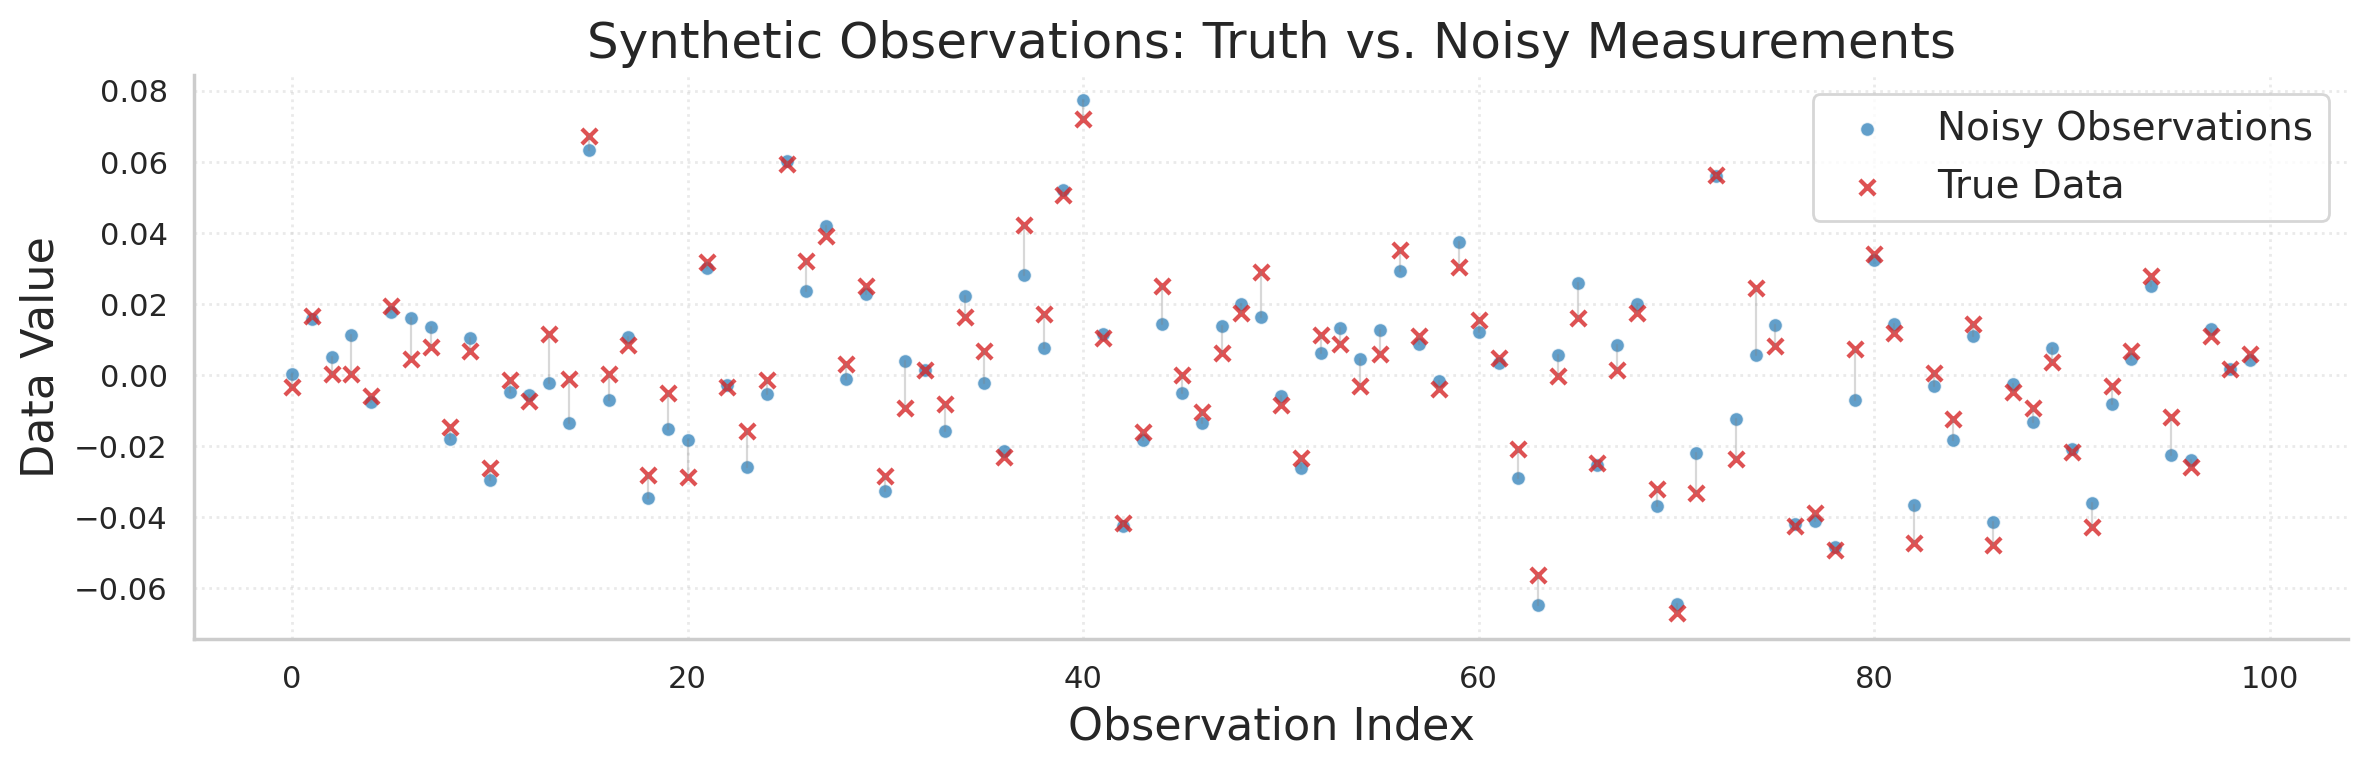

In [23]:
# Create the synthetic true model
m_bar = Function(M, evaluate_callable=lambda x: np.exp(-((x - function_domain.center)/0.5)**2) * np.sin(5 * np.pi * x) + x)

# Publication-quality true model plot
fig_title = "True Model"
filename = os.path.join(figures_folder, fig_title.replace(" ", "_").lower() + ".png")

plt.figure(figsize=(12, 4), dpi=200)
plt.plot(x, m_bar.evaluate(x), color='tab:red', linewidth=2.5, label=r'$\bar{m}(x)$')
plt.title(r"True Model $\bar{m}(x) = \sin(2\pi x)$", fontsize=18)
plt.xlabel(r"$x$", fontsize=16)
plt.ylabel("Model Value", fontsize=16)
plt.legend(fontsize=14)
plt.grid(True, linestyle=':', alpha=0.4)
sns.despine()
plt.tight_layout()
plt.savefig(filename, dpi=300, bbox_inches='tight')
plt.savefig(filename.replace('.png', '.pdf'), bbox_inches='tight')
plt.show()

# Generate synthetic observations
print("Generating synthetic data...")
d_bar = G(m_bar)  # Clean observations
noise_level = 0.1 * np.max(d_bar)
np.random.seed(42)  # For reproducibility
d_tilde = d_bar + np.random.normal(0, noise_level, d_bar.shape)  # Noisy observations

print(f"Signal-to-noise ratio: {np.max(d_bar) / noise_level:.1f}")
print(f"Number of observations: {len(d_tilde)}")

# Publication-quality data comparison plot
fig_title = "Synthetic Observations"
filename = os.path.join(figures_folder, fig_title.replace(" ", "_").lower() + ".png")

plt.figure(figsize=(12, 4), dpi=200)
data_indices = np.arange(len(d_bar))

# Plot connection lines between true and noisy data
for i in range(len(d_bar)):
    plt.plot([i, i], [d_bar[i], d_tilde[i]], color='gray', alpha=0.3, linewidth=0.8)

# Plot the data points
plt.scatter(data_indices, d_tilde, label='Noisy Observations',
           color='tab:blue', alpha=0.7, marker='o', s=25, edgecolors='white', linewidths=0.5)
plt.scatter(data_indices, d_bar, label='True Data',
           color='tab:red', alpha=0.8, marker='x', s=30, linewidths=1.5)

plt.xlabel('Observation Index', fontsize=16)
plt.ylabel('Data Value', fontsize=16)
plt.title('Synthetic Observations: Truth vs. Noisy Measurements', fontsize=18)
plt.legend(fontsize=14)
plt.grid(True, linestyle=':', alpha=0.4)
sns.despine()
plt.tight_layout()
plt.savefig(filename, dpi=300, bbox_inches='tight')
plt.savefig(filename.replace('.png', '.pdf'), bbox_inches='tight')
plt.show()

## Data Noise Model

### Gaussian Noise Assumption

We model the measurement noise as independent Gaussian with known variance:
$$\bm{\eta} \sim \mathcal{N}(\mathbf{0}, \mathbf{C}_{\mathcal{D}})$$

where $\mathbf{C}_{\mathcal{D}} = \sigma^2 \mathbf{I}$ represents uncorrelated measurement errors. This gives us the data measure:
$$\mu_{\mathcal{D}} = \mathcal{N}(\mathbf{\tilde{d}}, \mathbf{C}_{\mathcal{D}})$$

The choice of diagonal covariance assumes that measurement errors are independent across different data points, which is a common assumption in many practical applications.

In [24]:
# Define data noise covariance
noise_variance = (0.1 * np.max(d_tilde))**2  # 10% of peak signal
C_D_matrix = noise_variance * np.eye(N_d)

print(f"Data noise standard deviation: {np.sqrt(noise_variance):.4f}")
print(f"Relative noise level: {100 * np.sqrt(noise_variance) / np.max(d_tilde):.1f}%")

# Create data measure with observed data as mean and noise covariance
# This represents: d̃ ~ N(d̃, C_D) where d̃ are the observed noisy measurements
gaussian_D = GaussianMeasure.from_covariance_matrix(D, C_D_matrix, expectation=d_tilde)

Data noise standard deviation: 0.0077
Relative noise level: 10.0%


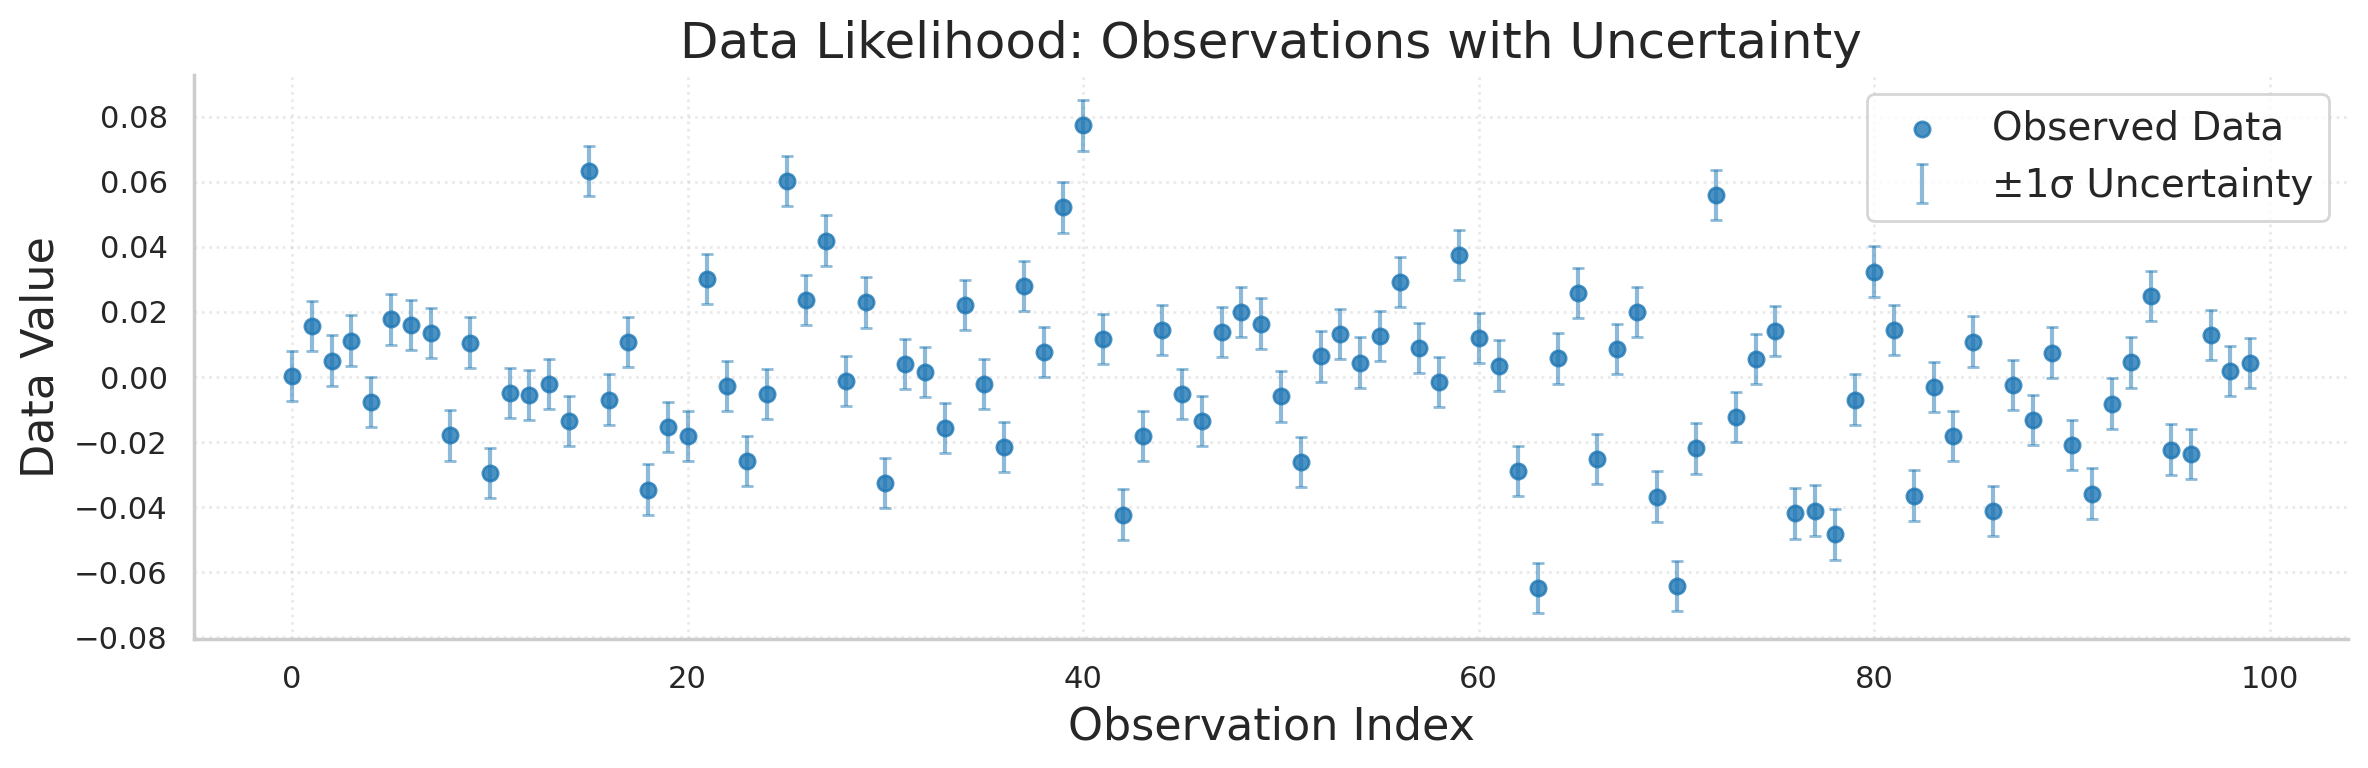

In [25]:
# Visualize the data measure (observed data with uncertainty)
mean_values = gaussian_D.expectation
std_values = np.sqrt(np.diag(gaussian_D.covariance.matrix(dense=True)))

fig_title = "Data Likelihood Distribution"
filename = os.path.join(figures_folder, fig_title.replace(" ", "_").lower() + ".png")

plt.figure(figsize=(12, 4), dpi=200)
data_indices = np.arange(len(mean_values))

plt.scatter(data_indices, mean_values, label='Observed Data', color='tab:blue', alpha=0.8, s=30)
plt.errorbar(data_indices, mean_values, yerr=std_values, fmt='none',
            color='tab:blue', alpha=0.5, capsize=2, capthick=1,
            label='±1σ Uncertainty')

plt.title("Data Likelihood: Observations with Uncertainty", fontsize=18)
plt.xlabel('Observation Index', fontsize=16)
plt.ylabel('Data Value', fontsize=16)
plt.legend(fontsize=14)
plt.grid(True, linestyle=':', alpha=0.4)
sns.despine()
plt.tight_layout()
plt.savefig(filename, dpi=300, bbox_inches='tight')
plt.savefig(filename.replace('.png', '.pdf'), bbox_inches='tight')
plt.show()

## SOLA Operator Construction

### Computing the Optimal Operator

We now compute the optimal SOLA operator $\mathbf{X}$ and related quantities:

1. **Normal operator**: $\Lambda = GG^*$ (Gram matrix of the forward operator)
2. **Regularized inverse**: $W^{-1} = (\Lambda + \mathbf{C}_{\mathcal{D}})^{-1}$
3. **Generalized inverse**: $G^{\dagger} = G^* W^{-1}$ 
4. **SOLA operator**: $\mathbf{X} = \mathcal{T} G^{\dagger}$

The regularized inverse $W^{-1}$ incorporates both the ill-conditioning of the forward problem and the data noise, providing a numerically stable solution.

In [26]:
# Compute SOLA operator components
print("Computing SOLA operator...")

# Step 1: Compute normal operator Λ = GG*
print("  - Computing Gram matrix...")
Lambda = LinearOperator.from_matrix(D, D, G.compute_gram_matrix())

# Step 2: Solve (Λ + C_D)^{-1} using Cholesky decomposition
print("  - Computing regularized inverse...")
cholesky_solver = CholeskySolver(galerkin=True)
W_inv = cholesky_solver(Lambda + gaussian_D.covariance)

# Step 3: Compute generalized inverse G† = G* W^{-1}
print("  - Computing generalized inverse...")
G_inv = G.adjoint @ W_inv

# Step 4: Compute SOLA operator X = T G†
print("  - Computing SOLA operator...")
X = T @ G_inv

print("✓ SOLA operator construction complete!")

Computing SOLA operator...
  - Computing Gram matrix...


/home/adrian/PhD/Inferences/pygeoinf/pygeoinf/interval/l2_functions.py:265: UserWarning: Point evaluation is not well-defined for general L² functions. Consider using a Sobolev space with s > 1/2 for point evaluation.
  warnings.warn(


  - Computing regularized inverse...
  - Computing generalized inverse...
  - Computing SOLA operator...
✓ SOLA operator construction complete!


## Model Reconstruction (Optional)

### Least-Norm Solution

Although our primary goal is property inference rather than full model reconstruction, we can still compute the model that corresponds to our estimate. This is the least-norm solution:

$$\tilde{m} = G^{\dagger}(\mathbf{\tilde{d}})$$

where $G^{\dagger}$ is the regularized generalized inverse we computed above. This model represents the smoothest solution consistent with the noisy data.

In [27]:
# Compute the least-norm model reconstruction from noisy data
print("Computing model reconstruction...")
m_tilde = G_inv(d_tilde)

# Compute reconstruction error
reconstruction_error = np.sqrt(np.mean((m_tilde.evaluate(x) - m_bar.evaluate(x))**2))
print(f"RMS reconstruction error: {reconstruction_error:.4f}")
print(f"Relative error: {100 * reconstruction_error / np.std(m_bar.evaluate(x)):.1f}%")

Computing model reconstruction...
RMS reconstruction error: 0.6779
Relative error: 109.8%


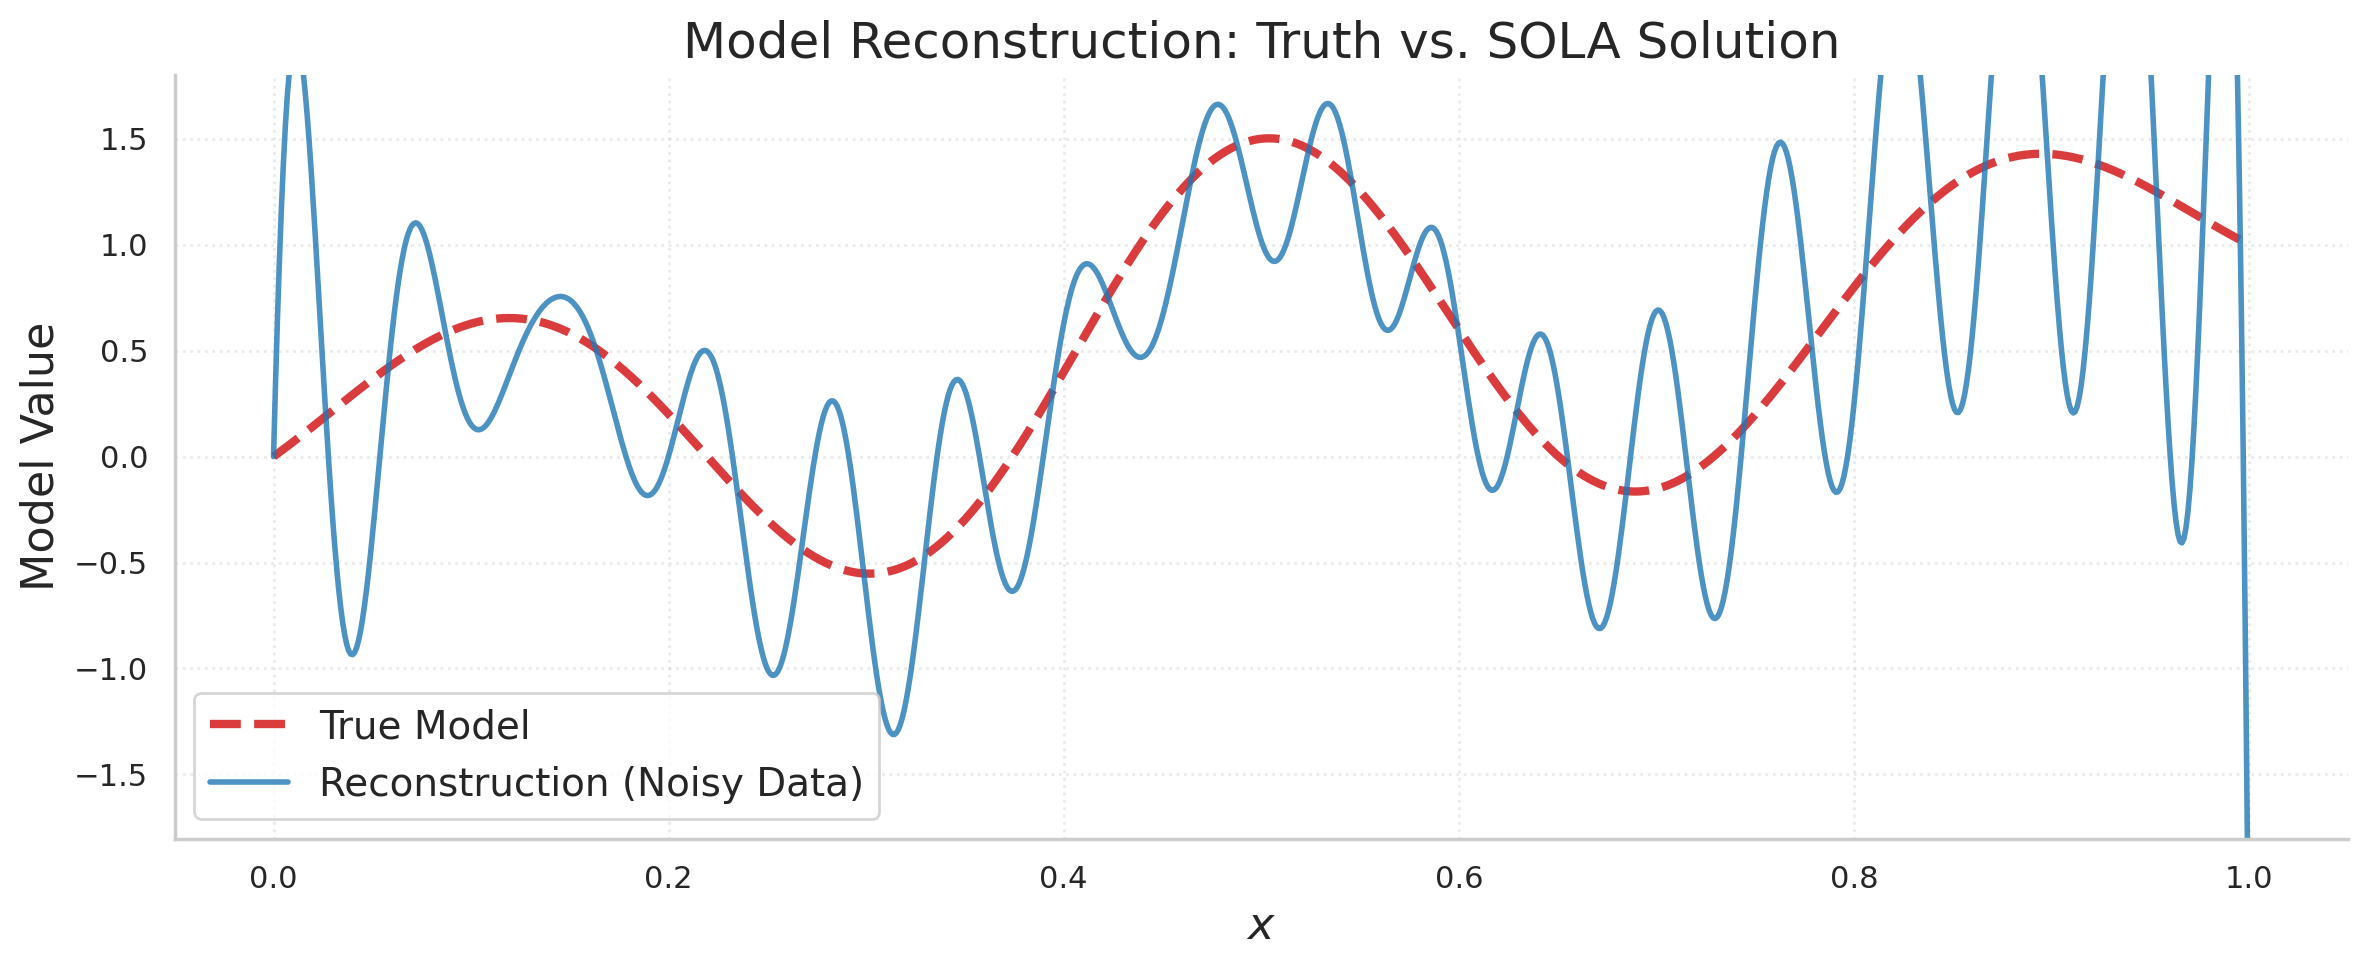

/home/adrian/PhD/Inferences/pygeoinf/pygeoinf/interval/l2_functions.py:265: UserWarning: Point evaluation is not well-defined for general L² functions. Consider using a Sobolev space with s > 1/2 for point evaluation.
  warnings.warn(



Data misfit: 0.0506
Model reconstruction shows the regularized solution from noisy data


In [ ]:
# Publication-quality model reconstruction plot
fig_title = "Model Reconstruction Comparison"
filename = os.path.join(figures_folder, fig_title.replace(" ", "_").lower() + ".png")

plt.figure(figsize=(12, 5), dpi=200)
plt.plot(x, m_bar.evaluate(x), label='True Model', linestyle='--',
         color='tab:red', linewidth=3, alpha=0.9)
plt.plot(x, m_tilde.evaluate(x), label='Reconstruction (Noisy Data)',
         color='tab:blue', alpha=0.8, linewidth=2)

plt.ylim(np.max(m_bar.evaluate(x)) * -1.2, np.max(m_bar.evaluate(x)) * 1.2)
plt.title('Model Reconstruction: Truth vs. Least Norm Solution', fontsize=18)
plt.xlabel(r'$x$', fontsize=16)
plt.ylabel('Model Value', fontsize=16)
plt.legend(fontsize=14)
plt.grid(True, linestyle=':', alpha=0.4)
sns.despine()
plt.tight_layout()
plt.savefig(filename, dpi=300, bbox_inches='tight')
plt.savefig(filename.replace('.png', '.pdf'), bbox_inches='tight')
plt.show()

# Compute data fit
data_misfit = np.linalg.norm(G(m_tilde) - d_tilde)
print(f"\nData misfit: {data_misfit:.4f}")
print(f"Model reconstruction shows the regularized solution from noisy data")

## Property Inference with Uncertainty

### Push-forward of Data Measure

We obtain our property estimates by pushing the data measure forward through the SOLA operator:

$$\mu_{\mathcal{P}} = \mathbf{X}_* \mu_{\mathcal{D}}$$

This automatically computes:
- **Property mean**: $\mathbf{\tilde{p}} = \mathbf{X}(\mathbf{\tilde{d}})$
- **Property covariance**: $\mathbf{C}_{\mathcal{P}} = \mathbf{X} \mathbf{C}_{\mathcal{D}} \mathbf{X}^*$

The resulting measure $\mu_{\mathcal{P}} = \mathcal{N}(\mathbf{\tilde{p}}, \mathbf{C}_{\mathcal{P}})$ provides both point estimates and uncertainty quantification for each property.

In [29]:
# Push forward the data measure through X to get property measure
print("Computing property measure via push-forward...")
# This automatically computes: mean = X(data_mean), covariance = X @ C_D @ X.adjoint
property_measure = gaussian_D.affine_mapping(operator=X)

# Compute true properties for comparison
p_bar = T(m_bar)  # true property values

print(f"Property measure computed for {N_p} target locations")
print(f"Property mean range: [{property_measure.expectation.min():.3f}, {property_measure.expectation.max():.3f}]")
print(f"True property range: [{p_bar.min():.3f}, {p_bar.max():.3f}]")

Computing property measure via push-forward...
Property measure computed for 20 target locations
Property mean range: [-0.408, 1.480]
True property range: [-0.381, 1.332]
Property measure computed for 20 target locations
Property mean range: [-0.408, 1.480]
True property range: [-0.381, 1.332]


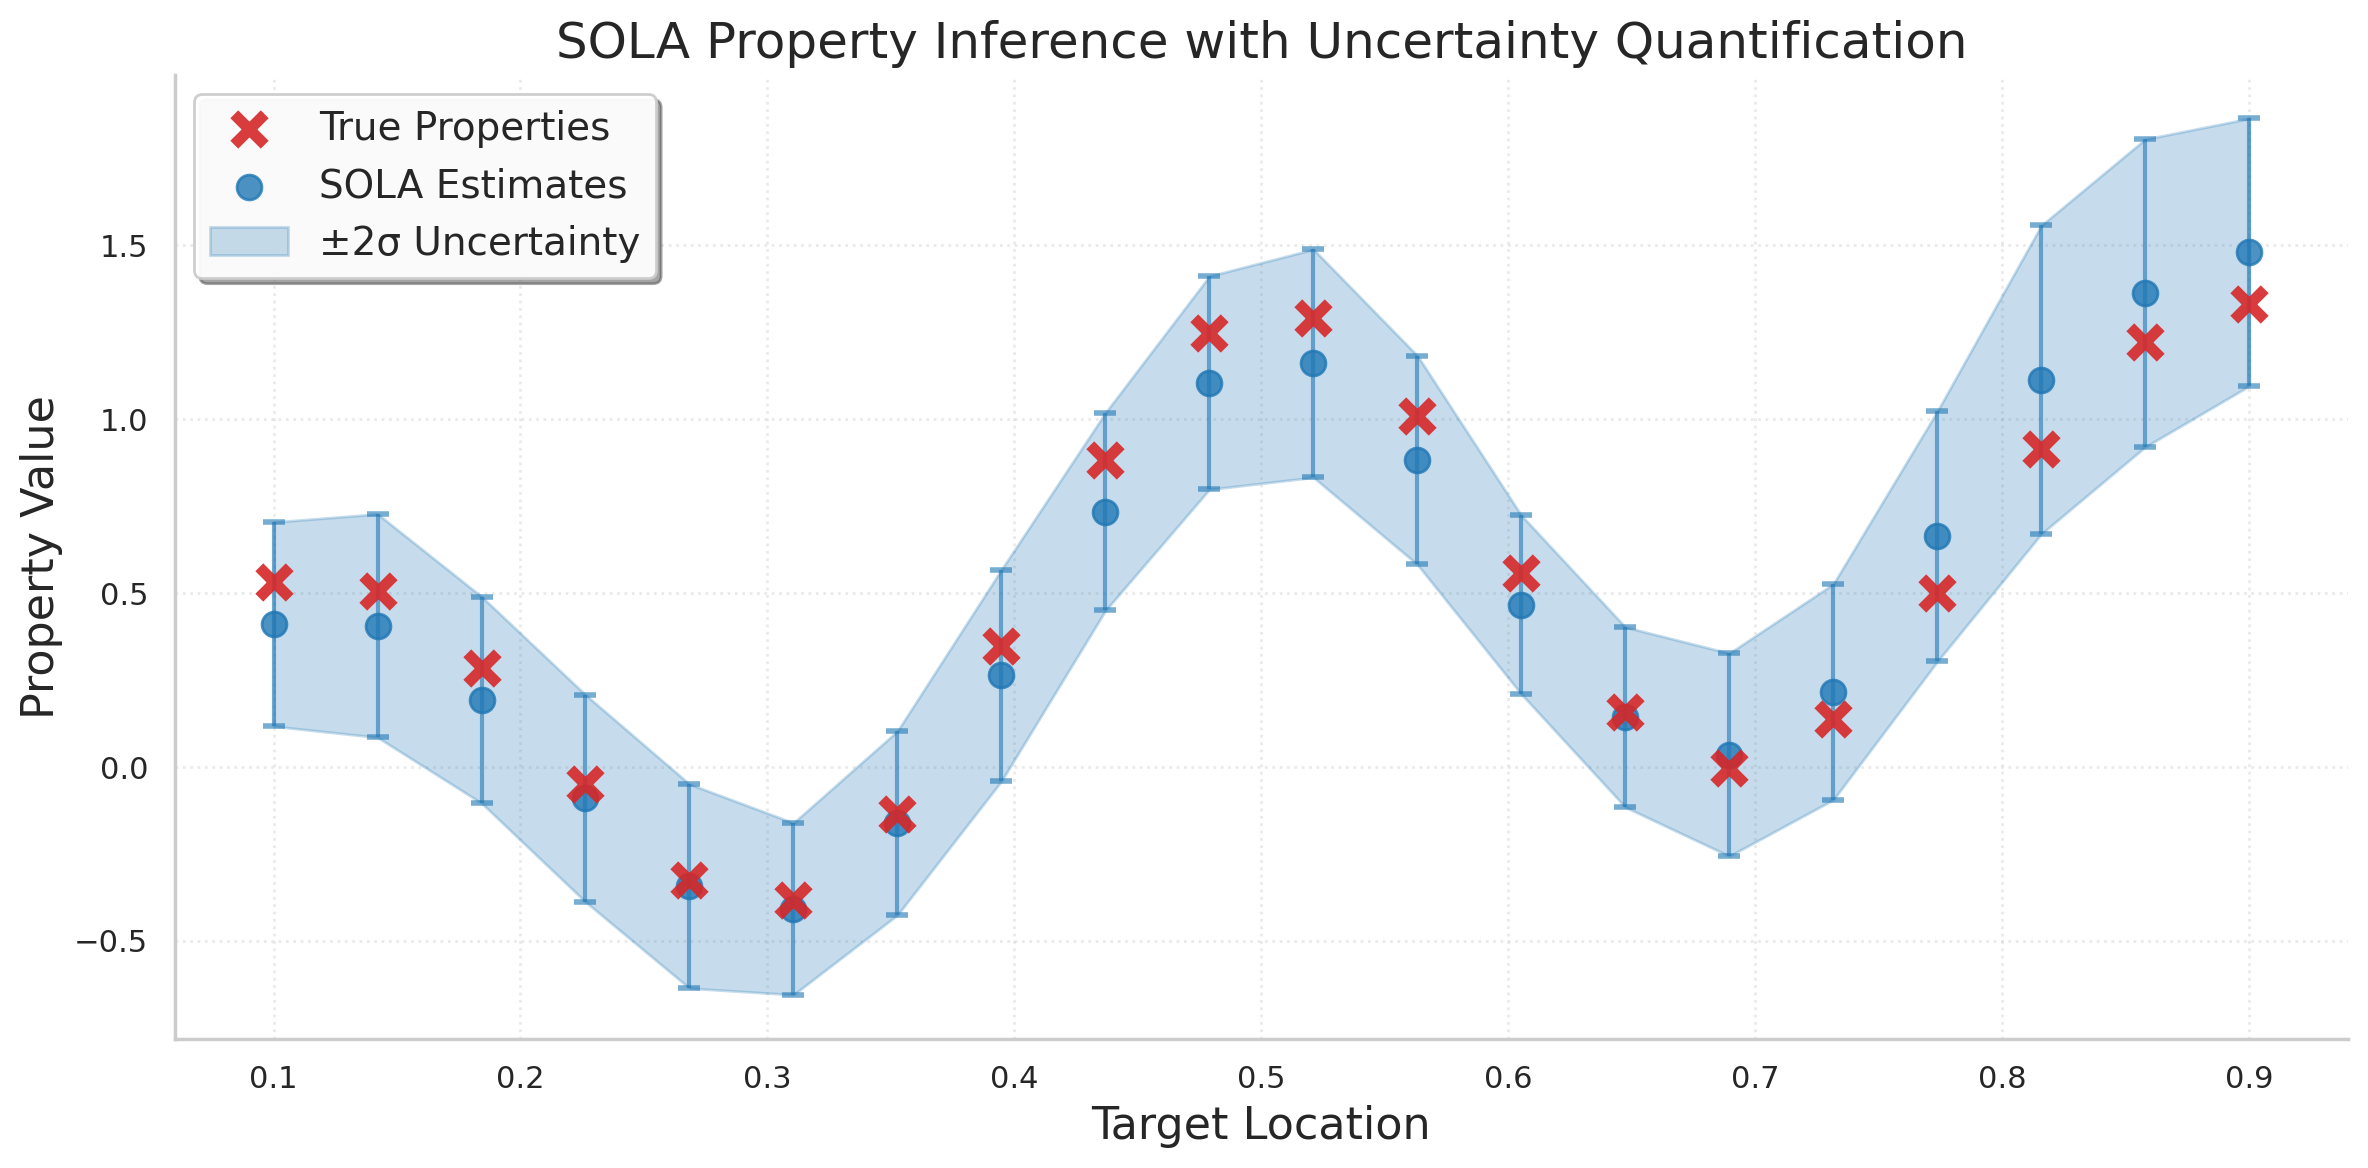


PROPERTY INFERENCE SUMMARY
Properties within ±2σ: 20/20 (100.0%)
Mean absolute error: 0.0965
RMS error: 0.1104
Max error: 0.1983
Average uncertainty (2σ): 0.3142


In [30]:
# Visualize property measure with uncertainty quantification
fig_title = "Property Inference Results"
filename = os.path.join(figures_folder, fig_title.replace(" ", "_").lower() + ".png")

plt.figure(figsize=(12, 6), dpi=200)

# Get the mean from the property measure
p_mean = property_measure.expectation

# Compute standard deviations from the covariance matrix
p_std = np.zeros(N_p)
for i in range(N_p):
    basis_vec = P.basis_vector(i)
    p_std[i] = np.sqrt(P.inner_product(property_measure.covariance(basis_vec), basis_vec))

# Plot with enhanced styling
plt.scatter(centers, p_bar, label='True Properties',
           color='tab:red', marker='x', s=120, alpha=0.9, linewidths=4, zorder=10)
plt.scatter(centers, p_mean, label='SOLA Estimates',
           color='tab:blue', marker='o', s=80, alpha=0.8, zorder=5)

# Add uncertainty bands (mean ± 2σ)
plt.fill_between(centers, p_mean - 2*p_std, p_mean + 2*p_std,
                alpha=0.25, color='tab:blue', label='±2σ Uncertainty', zorder=1)
plt.errorbar(centers, p_mean, yerr=2*p_std, fmt='none',
            ecolor='tab:blue', alpha=0.6, capsize=4, capthick=2, zorder=3)

plt.title('SOLA Property Inference with Uncertainty Quantification', fontsize=18)
plt.xlabel('Target Location', fontsize=16)
plt.ylabel('Property Value', fontsize=16)
plt.grid(True, linestyle=':', alpha=0.4)
plt.legend(fontsize=14, frameon=True, fancybox=True, shadow=True, framealpha=0.95)
sns.despine()
plt.tight_layout()
plt.savefig(filename, dpi=300, bbox_inches='tight')
plt.savefig(filename.replace('.png', '.pdf'), bbox_inches='tight')
plt.show()

# Quantitative assessment
property_errors = np.abs(p_mean - p_bar)
within_2sigma = np.sum(property_errors <= 2*p_std)

print("\n" + "="*50)
print("PROPERTY INFERENCE SUMMARY")
print("="*50)
print(f"Properties within ±2σ: {within_2sigma}/{len(p_bar)} ({100*within_2sigma/len(p_bar):.1f}%)")
print(f"Mean absolute error: {np.mean(property_errors):.4f}")
print(f"RMS error: {np.sqrt(np.mean(property_errors**2)):.4f}")
print(f"Max error: {np.max(property_errors):.4f}")
print(f"Average uncertainty (2σ): {np.mean(2*p_std):.4f}")
print("="*50)

## Unimodular Constraint Enhancement

### Imposing Unimodularity

The standard SOLA solution may not preserve certain physical constraints. A common requirement is **unimodularity**: the property operator should correctly recover uniform fields. Specifically, if $m(x) = 1$ everywhere, then each property should equal 1.

We impose this constraint by modifying the SOLA operator:
$$\mathbf{X}_{\text{uni}} = \mathbf{X} - \frac{(\mathbf{X}(\mathbf{v}) - \mathbf{w})}{\beta} \mathbf{u}^T$$

where:
- $\mathbf{v} = G(\mathbf{1})$ (forward operator applied to constant field)
- $\mathbf{w} = \mathbf{1}$ (desired output for constant field)  
- $\mathbf{u} = W^{-1}(\mathbf{v})$ (weighted projection vector)
- $\beta = \mathbf{v}^T \mathbf{u}$ (normalization factor)

This ensures that $\mathbf{X}_{\text{uni}}(G(\mathbf{1})) = \mathbf{1}$, preserving the physical interpretation of the properties.

In [31]:
# Imposing unimodularity constraint
print("Computing unimodular SOLA operator...")

# Step 1: Create constant unit function
M_one = Function(M, evaluate_callable=lambda x: np.ones_like(x))

# Step 2: Apply forward operator to get v = G(1)
v = G(M_one)

# Step 3: Define desired output for constant field
w = np.ones(N_p)

# Step 4: Compute weighted projection u = W^{-1}(v)
u = W_inv(v)

# Step 5: Compute normalization factor β = v^T u
beta = D.inner_product(v, u)

# Step 6: Construct correction term
correction = LinearOperator.from_matrix(D, P, np.outer((X(v) - w) / beta, u))

# Step 7: Apply correction to get unimodular operator
X_unimodular = X - correction

print(f"Unimodularity check: X(G(1)) = {X(v)}")
print(f"Unimodular check: X_uni(G(1)) = {X_unimodular(v)}")
print("✓ Unimodular constraint applied!")

# Compute property measure with unimodular operator
property_measure_unimodular = gaussian_D.affine_mapping(operator=X_unimodular)

Computing unimodular SOLA operator...


/home/adrian/PhD/Inferences/pygeoinf/pygeoinf/interval/l2_functions.py:265: UserWarning: Point evaluation is not well-defined for general L² functions. Consider using a Sobolev space with s > 1/2 for point evaluation.
  warnings.warn(


Unimodularity check: X(G(1)) = [0.99583821 0.99302795 0.99233744 0.99056535 0.99042112 0.99208336
 0.99093906 0.98850016 0.98997173 0.98984221 0.98843733 0.9889853
 0.99090779 0.98968859 0.98750548 0.98816248 0.98670431 0.98288217
 0.98372765 0.98690236]
Unimodular check: X_uni(G(1)) = [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
✓ Unimodular constraint applied!
Unimodular check: X_uni(G(1)) = [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
✓ Unimodular constraint applied!


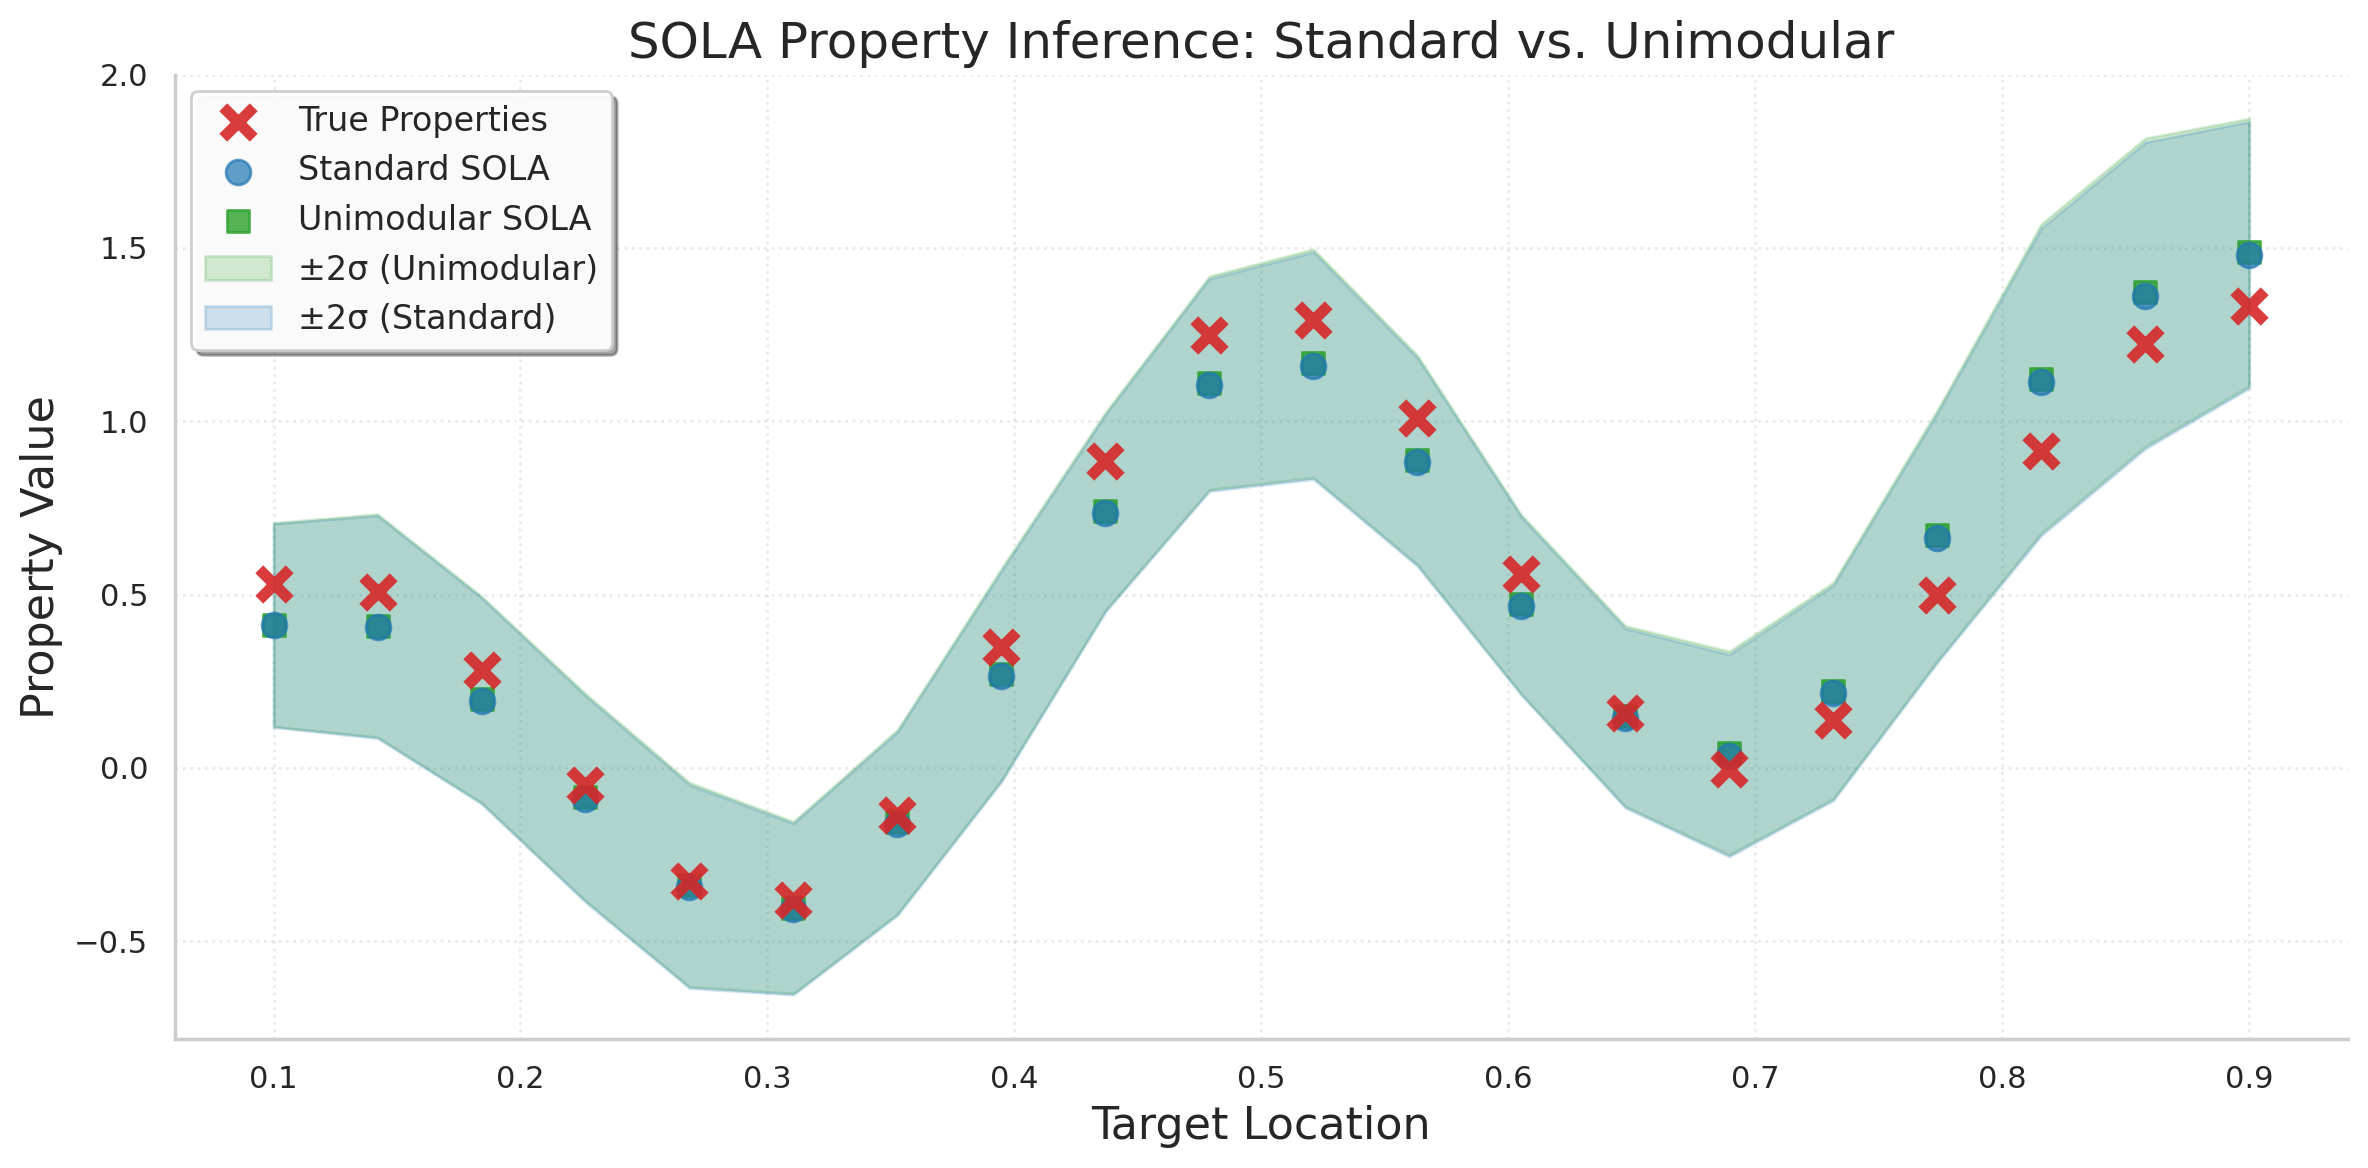


STANDARD vs. UNIMODULAR SOLA COMPARISON
Standard SOLA - Mean absolute error: 0.0965
Unimodular SOLA - Mean absolute error: 0.0953
Standard SOLA - RMS error: 0.1104
Unimodular SOLA - RMS error: 0.1107
Improvement ratio: 1.01


In [32]:
# Visualize comparison between standard and unimodular SOLA
fig_title = "SOLA Standard vs Unimodular Comparison"
filename = os.path.join(figures_folder, fig_title.replace(" ", "_").lower() + ".png")

plt.figure(figsize=(12, 6), dpi=200)

# Get means from both property measures
p_mean_standard = property_measure.expectation
p_mean_unimodular = property_measure_unimodular.expectation

# Compute standard deviations (assume similar uncertainty structure)
p_std_standard = np.zeros(N_p)
p_std_unimodular = np.zeros(N_p)

for i in range(N_p):
    basis_vec = P.basis_vector(i)
    p_std_standard[i] = np.sqrt(P.inner_product(property_measure.covariance(basis_vec), basis_vec))
    p_std_unimodular[i] = np.sqrt(P.inner_product(property_measure_unimodular.covariance(basis_vec), basis_vec))

# Plot comparisons
plt.scatter(centers, p_bar, label='True Properties',
           color='tab:red', marker='x', s=120, alpha=0.9, linewidths=4, zorder=10)
plt.scatter(centers, p_mean_standard, label='Standard SOLA',
           color='tab:blue', marker='o', s=80, alpha=0.7, zorder=6)
plt.scatter(centers, p_mean_unimodular, label='Unimodular SOLA',
           color='tab:green', marker='s', s=60, alpha=0.8, zorder=5)

# Add uncertainty bands for unimodular SOLA
plt.fill_between(centers, p_mean_unimodular - 2*p_std_unimodular, p_mean_unimodular + 2*p_std_unimodular,
                alpha=0.2, color='tab:green', label='±2σ (Unimodular)', zorder=1)

# Add uncertainty bands for standard SOLA
plt.fill_between(centers, p_mean_standard - 2*p_std_standard, p_mean_standard + 2*p_std_standard,
                alpha=0.2, color='tab:blue', label='±2σ (Standard)', zorder=1)



plt.title('SOLA Property Inference: Standard vs. Unimodular', fontsize=18)
plt.xlabel('Target Location', fontsize=16)
plt.ylabel('Property Value', fontsize=16)
plt.grid(True, linestyle=':', alpha=0.4)
plt.legend(fontsize=12, frameon=True, fancybox=True, shadow=True, framealpha=0.95)
sns.despine()
plt.tight_layout()
plt.savefig(filename, dpi=300, bbox_inches='tight')
plt.savefig(filename.replace('.png', '.pdf'), bbox_inches='tight')
plt.show()

# Quantitative comparison
errors_standard = np.abs(p_mean_standard - p_bar)
errors_unimodular = np.abs(p_mean_unimodular - p_bar)

print("\n" + "="*60)
print("STANDARD vs. UNIMODULAR SOLA COMPARISON")
print("="*60)
print(f"Standard SOLA - Mean absolute error: {np.mean(errors_standard):.4f}")
print(f"Unimodular SOLA - Mean absolute error: {np.mean(errors_unimodular):.4f}")
print(f"Standard SOLA - RMS error: {np.sqrt(np.mean(errors_standard**2)):.4f}")
print(f"Unimodular SOLA - RMS error: {np.sqrt(np.mean(errors_unimodular**2)):.4f}")
print(f"Improvement ratio: {np.mean(errors_standard)/np.mean(errors_unimodular):.2f}")
print("="*60)